In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os
import random
import re
import shutil
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [4]:
dir = r"C:\Users\alvar\Desktop\Bioinfor y Bioest\TFM\Rembrand\Glioma_clasificación"
os.listdir(dir)

['Clasificación_glioma',
 'G_II',
 'G_III',
 'G_III_cropped',
 'G_II_cropped',
 'G_IV',
 'G_IV_cropped',
 'II',
 'III',
 'IV',
 'Selected_II',
 'Selected_III',
 'Selected_IV',
 'sin_cropping',
 'test',
 'train',
 'val']

In [60]:
# Configuración
input_folders = [dir + "\G_II_cropped", dir + "\G_III_cropped", dir + "\G_IV_cropped"]  # Lista de carpetas con imágenes
output_base = "dir"  # Carpeta base donde se guardarán los conjuntos
data_split = {"train": 0.6, "val": 0.15, "test": 0.25}  # Proporciones

# Crear directorios de salida
for subset in ["train", "val", "test"]:
    subset_path = os.path.join(dir, subset)
    if not os.path.exists(subset_path):
        os.makedirs(subset_path)

# Función para copiar imágenes

def copy_images(images, subset, label):
    subset_path = os.path.join(dir, subset, label)
    if not os.path.exists(subset_path):
        os.makedirs(subset_path)
    for img in images:
        shutil.copy(img, subset_path)

# Procesar cada carpeta
for folder in input_folders:
    label = os.path.basename(folder)  # Usar el nombre de la carpeta como etiqueta
    all_images = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    
    # Mezclar aleatoriamente
    random.shuffle(all_images)
    
    # Calcular tamaño de cada conjunto
    total = len(all_images)
    train_size = int(total * data_split["train"])
    val_size = int(total * data_split["val"])
    
    # Dividir las imágenes
    train_images = all_images[:train_size]
    val_images = all_images[train_size:train_size + val_size]
    test_images = all_images[train_size + val_size:]
    
    # Copiar las imágenes a las carpetas correspondientes
    copy_images(train_images, "train", label)
    copy_images(val_images, "val", label)
    copy_images(test_images, "test", label)

print("División completada. Las imágenes están organizadas en la carpeta output.")


División completada. Las imágenes están organizadas en la carpeta output.


In [5]:
train_path = dir + '/train/'
test_path = dir + '/test/'
validation_path = dir + '/val/'
print("train path:", train_path)
print("test path:", test_path)
print("validation path:", validation_path)

train path: C:\Users\alvar\Desktop\Bioinfor y Bioest\TFM\Rembrand\Glioma_clasificación/train/
test path: C:\Users\alvar\Desktop\Bioinfor y Bioest\TFM\Rembrand\Glioma_clasificación/test/
validation path: C:\Users\alvar\Desktop\Bioinfor y Bioest\TFM\Rembrand\Glioma_clasificación/val/


In [6]:
os.listdir(test_path)

['G_III_cropped', 'G_II_cropped', 'G_IV_cropped']

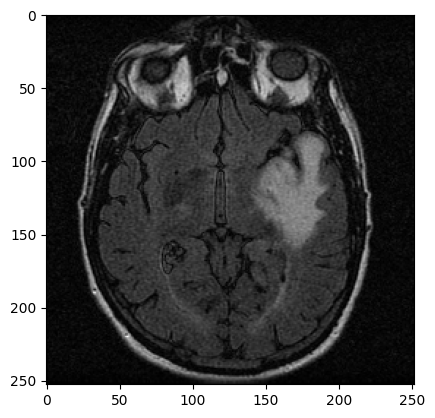

In [7]:
plt.imshow(plt.imread(train_path + 'G_II_cropped/' + '1-22_39.png'))

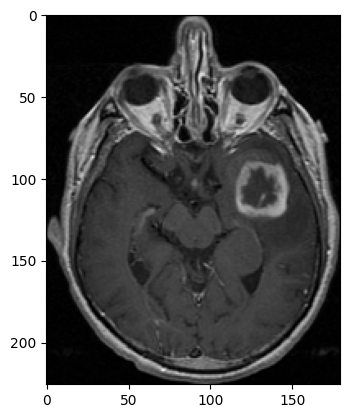

In [8]:
plt.imshow(plt.imread(train_path + 'G_III_cropped/' + '1-23_42.png'))

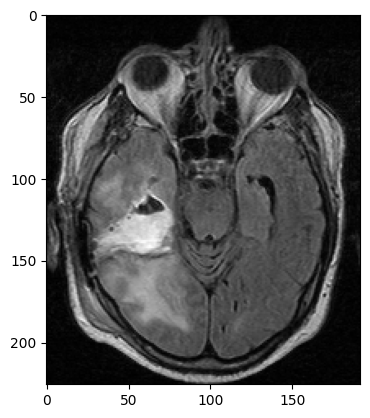

In [9]:
plt.imshow(plt.imread(train_path + 'G_IV_cropped/' + '1-13_239.png'))

In [10]:
image_generator = ImageDataGenerator(rotation_range=20,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.1,
                                     horizontal_flip=True)

In [12]:
image_generator.flow_from_directory(train_path)

Found 660 images belonging to 3 classes.


In [74]:
image_generator.flow_from_directory(test_path)

Found 278 images belonging to 3 classes.


In [13]:
image_generator.flow_from_directory(validation_path)

Found 164 images belonging to 3 classes.


In [ ]:
## Modelo VGG19

In [15]:
VGG19_model = VGG19(
                    include_top=False,
                    weights='imagenet',
                    input_shape=(240,240,3),
                    pooling='max',
                    classes= 3
                )

for layer in VGG19_model.layers:
    layer.trainable = False

In [16]:
model_class_1 = Sequential([
    VGG19_model,
    Dense(2560,activation='relu'),
    BatchNormalization(),
    Dense(1280, activation='relu'),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax')
])

In [17]:
model_class_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 2560)              1313280   
                                                                 
 batch_normalization (BatchN  (None, 2560)             10240     
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1280)              3278080   
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1024)              1

In [18]:
model_class_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=5e-05) ,loss = 'categorical_crossentropy',metrics = 'accuracy')

In [19]:
batch_size = 32

In [20]:
train_image_generator = image_generator.flow_from_directory(train_path,
                                                            target_size=(240, 240),
                                                            color_mode='rgb',
                                                            batch_size=batch_size,
                                                            class_mode='categorical')

Found 660 images belonging to 3 classes.


In [21]:
validation_image_generator = image_generator.flow_from_directory(validation_path,
                                                            target_size=(240, 240),
                                                            color_mode='rgb',
                                                            batch_size=batch_size,
                                                            class_mode='categorical')

Found 164 images belonging to 3 classes.


In [22]:
test_image_generator = image_generator.flow_from_directory(test_path,
                                                            target_size=(240, 240),
                                                            color_mode='rgb',
                                                            batch_size=batch_size,
                                                            class_mode='categorical',
                                                            shuffle = False)

Found 278 images belonging to 3 classes.


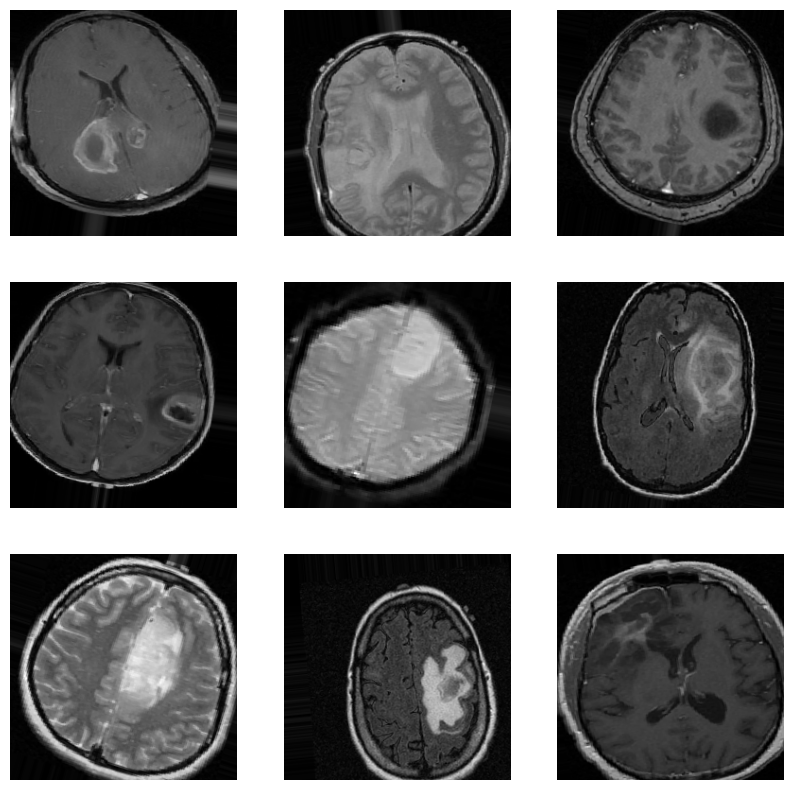

In [26]:
import matplotlib.pyplot as plt

# Mostrar un lote de imágenes generadas
sample_batch = next(train_image_generator)  # Obtener un lote de imágenes
images, labels = sample_batch

# Mostrar 9 imágenes del lote
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))  # Convertir a uint8 para mostrar correctamente
    plt.axis('off')
plt.show()

In [24]:
print(test_image_generator.class_indices)  # Verifica las clases


{'G_III_cropped': 0, 'G_II_cropped': 1, 'G_IV_cropped': 2}


In [25]:
history = model_class_1.fit(train_image_generator, validation_data=validation_image_generator, epochs=16)

Epoch 1/16
21/21 [==============================] - 78s 4s/step - loss: 1.2162 - accuracy: 0.4076 - val_loss: 1.9739 - val_accuracy: 0.4329
Epoch 2/16
21/21 [==============================] - 88s 4s/step - loss: 0.8471 - accuracy: 0.6197 - val_loss: 1.3257 - val_accuracy: 0.4268
Epoch 3/16
21/21 [==============================] - 87s 4s/step - loss: 0.7341 - accuracy: 0.6833 - val_loss: 1.2089 - val_accuracy: 0.4878
Epoch 4/16
21/21 [==============================] - 97s 5s/step - loss: 0.6403 - accuracy: 0.7379 - val_loss: 1.1045 - val_accuracy: 0.5305
Epoch 5/16
21/21 [==============================] - 109s 5s/step - loss: 0.5374 - accuracy: 0.7879 - val_loss: 0.9286 - val_accuracy: 0.5549
Epoch 6/16
21/21 [==============================] - 89s 4s/step - loss: 0.4951 - accuracy: 0.8348 - val_loss: 0.8980 - val_accuracy: 0.6159
Epoch 7/16
21/21 [==============================] - 93s 4s/step - loss: 0.4791 - accuracy: 0.8212 - val_loss: 0.9497 - val_accuracy: 0.6098
Epoch 8/16
21/21 [=

In [30]:
Metricas para el modelo con learning rate 5e-05 y 16 epocas

SyntaxError: invalid syntax (867844950.py, line 1)

In [27]:
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

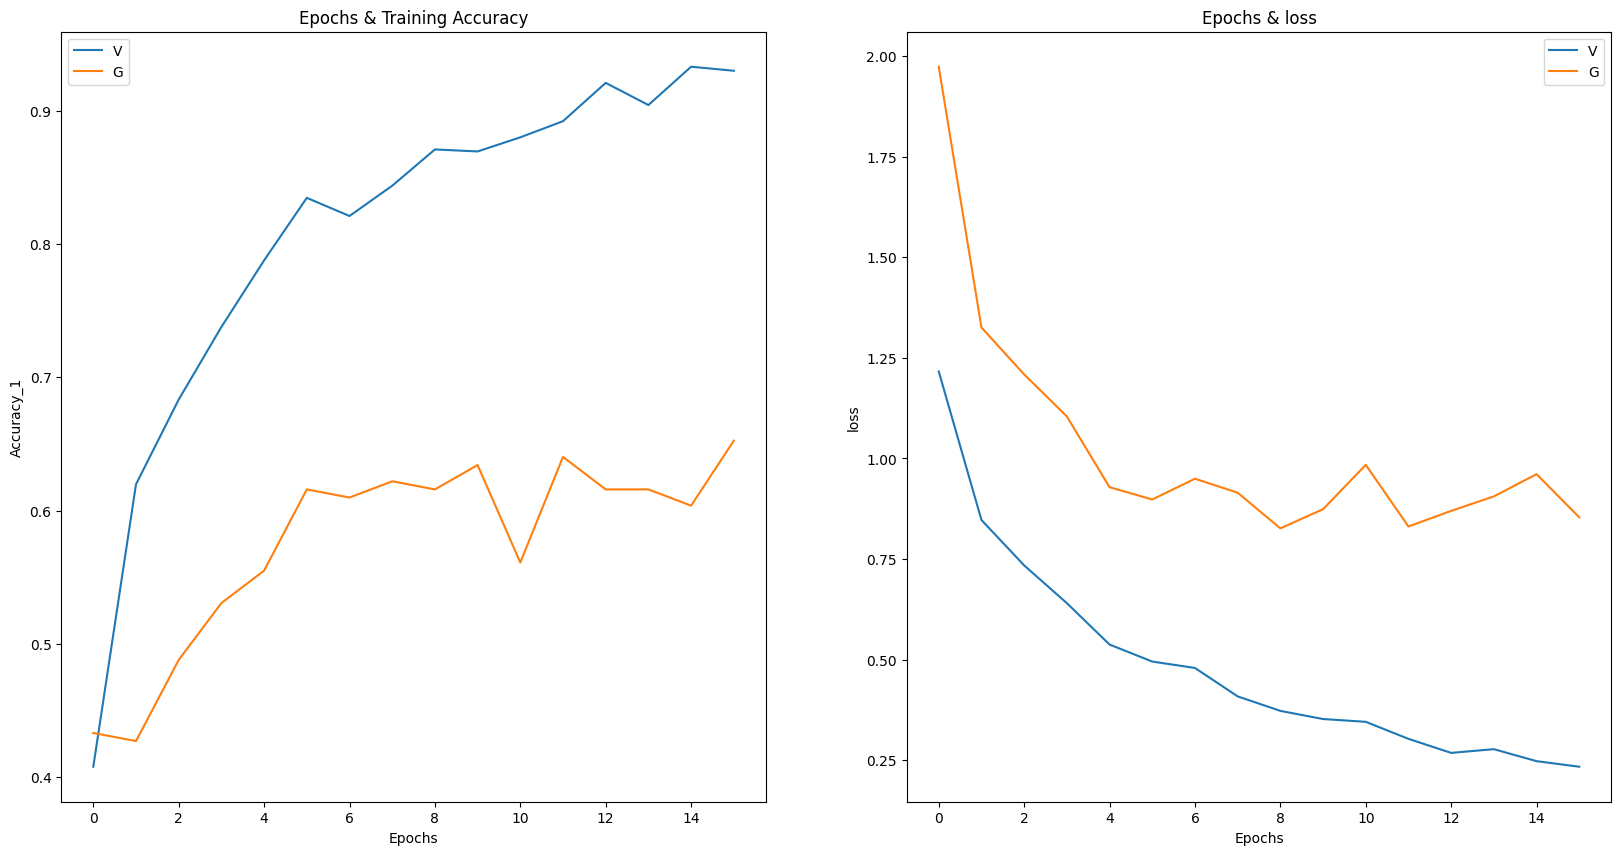

In [28]:
fig_1, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))

ax[0].plot(acc_1, label = 'Training accuracy')
ax[0].plot(val_acc_1, label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy_1')
ax[0].set_title('Epochs & Training Accuracy')
ax[0].legend("VGG19 Lr = 0.0005")


ax[1].plot(loss_1, label = 'Training loss')
ax[1].plot(val_loss_1, label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss')
ax[1].legend("VGG19 Lr = 0.0005")

In [29]:
# Predicción sobre los datos de prueba
y_pred_probs_1 = model_class_1.predict(test_image_generator, steps=len(test_image_generator), verbose=1)

# Convertir probabilidades en clases predichas (índices)
y_pred_1 = np.argmax(y_pred_probs_1, axis=1)
print(y_pred_1)
# Extraer las etiquetas reales desde el generador
y_true = test_image_generator.classes
print(y_true)

9/9 [==============================] - 24s 3s/step
[1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 2 1 1 0 0 2 0 0 1 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 1 1 0 1 0 2 0 0 0 2 0 0 2 0 0 1
 0 0 1 1 1 1 0 1 1 2 2 2 1 1 0 1 0 2 0 1 2 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1
 2 1 0 1 1 1 0 1 2 0 1 1 2 1 1 1 1 1 1 1 1 1 2 1 0 1 0 1 1 1 2 0 2 1 2 2 2
 0 2 1 2 1 1 0 2 1 0 1 1 1 2 1 1 2 1 2 0 2 0 2 2 2 2 0 2 2 0 0 2 2 0 2 1 0
 2 2 2 2 1 2 2 0 0 2 2 2 2 2 2 1 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 0
 2 0 2 0 2 0 2 2 2 2 2 2 0 0 2 2 2 0 2 2 0 2 0 2 1 0 2 1 0 2 0 2 1 0 2 2 2
 0 2 2 2 2 0 0 2 0 2 2 0 2 2 0 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 

In [92]:
print(y_pred_probs_1.shape)

(278, 3)


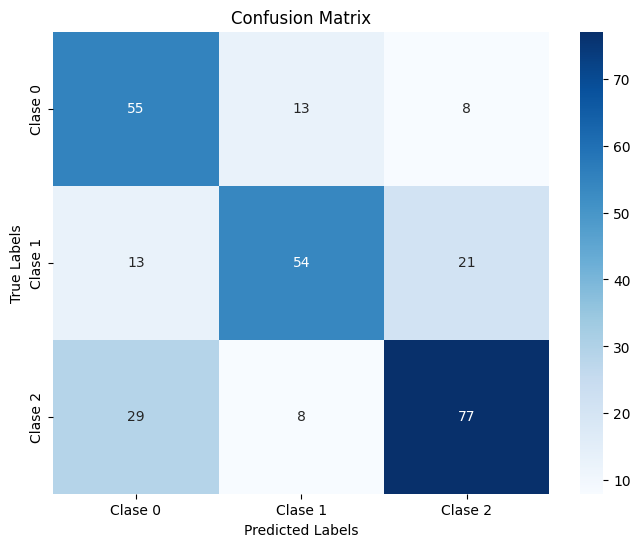

              precision    recall  f1-score   support

          II       0.57      0.72      0.64        76
         III       0.72      0.61      0.66        88
          IV       0.73      0.68      0.70       114

    accuracy                           0.67       278
   macro avg       0.67      0.67      0.67       278
weighted avg       0.68      0.67      0.67       278



In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de confusión
conf_matrix_1 = confusion_matrix(y_true, y_pred_1)

# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1", "Clase 2"], yticklabels=["Clase 0", "Clase 1", "Clase 2"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Imprimir un reporte de clasificación
report_1 = classification_report(y_true, y_pred_1, target_names=["II", "III", "IV"])
print(report_1)


In [ ]:
metricas para el modelo con Lr = 0.00005

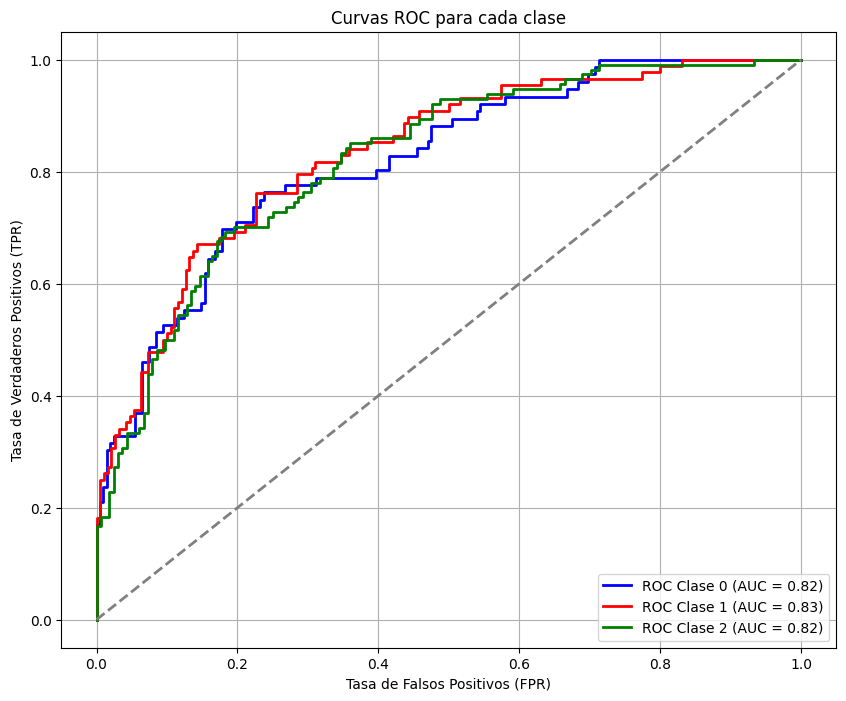

In [31]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

# Binarizamos las etiquetas reales (one-hot encoding)
n_classes = 3  # Número de clases
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Curvas ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular fpr, tpr y AUC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs_1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC Clase {i} (AUC = {roc_auc[i]:.2f})')

# Agregar línea base
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Personalización del gráfico
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para cada clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()